Problem Statement
------


For this case study, we will study a flash unit inside an air separation unit. 

The flowsheet that we will be using for this module is shown below. We will mix three streams of a mixture of nitrogen, oxygen, and nitrogen. The compositions of the streams were extracted from *A framework for efficient large scale equation-oriented flowsheet optimization*, Alexander W. Dowling and Lorenz T. Biegler, 2014

![](Air_flash.png)

The flash unit model, F101, represents the top tray of a low-pressure column. The stream LowP_1 is the feed of vapor stream from the low-pressure column, while the streams HighP_1 and HighP_2 are the recycle streams coming from the high-pressure column. We will utilize the Peng-Robinson equation of state for this flowsheet. The properties required for this module is available in the property example directory:

- idaes\generic_models\properties\core\examples\ASU_PR.py 

The property example contains two dictionaries:
* configuration: contains parameters obtained from The Properties of Gases and Liquids (1987) 4th edition and NIST.
* configuration_dowling_2015: contains parameters used in A framework for efficient large scale equation-oriented flowsheet optimization (2015) Dowling. The parameters are extracted from Properties of Gases and Liquids (1977) 3rd edition for Antoine's vapor equation and acentric factors and converted values from the Properties of Gases and Liquids (1977) 3rd edition

The state variables chosen for the property package are **mole fractions, molar flow, temperature, and pressure**. The components considered are **nitrogen, oxygen, and argon**. Therefore, every stream has 3 mole fractions, molar flow,  temperature, and pressure variables. 

In this example, we will simulate the following cases:

* Case 1: Adiabatic flash unit calculation in the 2-phase region.
* Case 2: Flash unit calculation in the vapor region.
* Case 3: Flash unit calculation in the liquid region.

Finally, we will show a sensitivity analysis over the influence of the temperature in the vapor-liquid split of the flash column and analyze how sensible the thermodynamic model is to the parameters used.

For the sensitivity analysis over the thermodynamic model and its parameters, we will create a second model utilizing parameters and equations from A framework for efficient large scale equation-oriented flowsheet optimization (2015) Dowling. 

In this tutorial, we will:

* Utilize the mixer and flash unit models.
* Utilize the Generic Property Package, which provides a flexible platform on which users can build property packages by calling upon libraries of modular sub-models to build up complex property calculations with the least effort possible.
* Demonstrate the manual initialization approach, including the use of the propagate_state method in idaes/core/util/initialization
* Fix state variables for different conditions and initialize and solve the flowsheet for these conditions.
* Create sensitivity analysis and create a plot from the results
* Create two different flowsheet models in the same notebook with two different parameter blocks.

## Setting up the problem in IDAES

In the following cell, we will be importing the necessary components from Pyomo and IDAES.

In [1]:
# Import objects from pyomo package
from pyomo.environ import (ConcreteModel,
                           SolverFactory,
                           TransformationFactory,
                           value,
                           units as pyunits)
from pyomo.network import Arc
from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

# Import idaes logger to set output levels
import idaes.logger as idaeslog

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Create the ConcreteModel and the FlowsheetBlock, and attach the flowsheet block to it.
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False}) 

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Add properties parameter blocks to the flowsheet with specifications
from idaes.generic_models.properties.core.examples.ASU_PR import configuration

# Add properties parameter blocks to the flowsheet with specifications
m.fs.props = GenericParameterBlock(default=configuration)

In [2]:
# Import unit models from the model library
from idaes.generic_models.unit_models import Mixer, Flash

m.fs.M101 = Mixer(default={"property_package": m.fs.props,
                           "inlet_list": ["LowP_1","HighP_1","HighP_2"]})

m.fs.F101 = Flash(default={"property_package": m.fs.props,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

# Create streams to define connectivity between unit models
m.fs.s01 = Arc(source=m.fs.M101.outlet, destination=m.fs.F101.inlet)

# Expand arcs
TransformationFactory("network.expand_arcs").apply_to(m)

# Call the degrees_of_freedom function, get intitial DOF
DOF_initial = degrees_of_freedom(m)
print("The initial DOF is {0}".format(DOF_initial))

The initial DOF is 20


## Case 1: Flash unit calculation in the 2-phase region.

In [3]:
m.fs.M101.LowP_1.mole_frac_comp[0, "nitrogen"].fix(0.9814)
m.fs.M101.LowP_1.mole_frac_comp[0, "argon"].fix(0.0106)
m.fs.M101.LowP_1.mole_frac_comp[0, "oxygen"].fix(0.0080)
m.fs.M101.LowP_1.flow_mol[0].fix(1.4667)
m.fs.M101.LowP_1.temperature.fix(77.430)
m.fs.M101.LowP_1.pressure.fix(101000)

m.fs.M101.HighP_1.mole_frac_comp[0, "nitrogen"].fix(0.9942)
m.fs.M101.HighP_1.mole_frac_comp[0, "argon"].fix(0.0014)
m.fs.M101.HighP_1.mole_frac_comp[0, "oxygen"].fix(0.0043)
m.fs.M101.HighP_1.flow_mol[0].fix(0.0486)
m.fs.M101.HighP_1.temperature.fix(84.0070)
m.fs.M101.HighP_1.pressure.fix(204630)

m.fs.M101.HighP_2.mole_frac_comp[0, "nitrogen"].fix(0.9832)
m.fs.M101.HighP_2.mole_frac_comp[0, "argon"].fix(0.0032)
m.fs.M101.HighP_2.mole_frac_comp[0, "oxygen"].fix(0.0135)
m.fs.M101.HighP_2.flow_mol[0].fix(0.7134)
m.fs.M101.HighP_2.temperature.fix(84.0070)
m.fs.M101.HighP_2.pressure.fix(204630)

# Fix unit models operating conditions
# Fix F101 Flash outlet temperature
m.fs.F101.deltaP.fix(0)
m.fs.F101.heat_duty[0].fix(0)

DOF_final = degrees_of_freedom(m)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


In [4]:
assert DOF_final == 0

### Flowsheet Initialization

IDAES includes pre-written initialization routines for all unit models. We will initialize the units in order using the propagate_state method in idaes/core/util/initialization. This method propagates values between Ports along Arcs. We will propagate the values between the mixer M101 and the flash unit F101 along the stream S01.

In [5]:
m.fs.M101.initialize(outlvl=idaeslog.INFO_LOW) 
propagate_state(m.fs.s01)
m.fs.F101.initialize(outlvl=idaeslog.INFO_LOW) 

### Obtaining Simulation Results

In [6]:
# Solve the simulation using ipopt
# Note: If the degrees of freedom = 0, we have a square problem
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-5}
result = solver.solve(m, tee=True)

Ipopt 3.13.2: tol=1e-05


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

In [7]:
from pyomo.opt import TerminationCondition, SolverStatus

# Check if termination condition is optimal
assert result.solver.termination_condition == TerminationCondition.optimal
assert result.solver.status == SolverStatus.ok

### View Results

In [8]:
# Display output report
m.fs.M101.report()
m.fs.F101.report()


Unit : fs.M101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                   LowP_1     HighP_1    HighP_2    Outlet  
    Total Molar Flowrate             1.4667   0.048600    0.71340     2.2286
    Total Mole Fraction nitrogen    0.98140    0.99420    0.98320    0.98229
    Total Mole Fraction argon      0.010600  0.0014000  0.0032000  0.0080309
    Total Mole Fraction oxygen    0.0080000  0.0043000   0.013500  0.0096802
    Temperature                      77.430     84.007     84.007     77.431
    Pressure                     1.0100e+05 2.0463e+05 2.0463e+05 1.0100e+05

Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Fixed : Bounds
          Heat Du

In [9]:
import pytest

# Check results
assert m.fs.F101.heat_duty[0].value == pytest.approx(0.0, abs=1e-1)

assert m.fs.F101.liq_outlet.flow_mol[0].value == pytest.approx(0.63350, abs=1e-2)
assert m.fs.F101.liq_outlet.mole_frac_comp[0, "nitrogen"].value == pytest.approx(0.96525, abs=1e-3)
assert m.fs.F101.liq_outlet.mole_frac_comp[0, "argon"].value == pytest.approx(0.014242, abs=1e-3)
assert m.fs.F101.liq_outlet.mole_frac_comp[0, "oxygen"].value == pytest.approx(0.020512, abs=1e-3)
assert m.fs.F101.liq_outlet.temperature[0].value == pytest.approx(77.430, abs=1e-2)
assert m.fs.F101.liq_outlet.pressure[0].value == pytest.approx(101000, abs=1)

assert m.fs.F101.vap_outlet.flow_mol[0].value == pytest.approx(1.5951, abs=1e-2)
assert m.fs.F101.vap_outlet.mole_frac_comp[0, "nitrogen"].value == pytest.approx(0.98906, abs=1e-3)
assert m.fs.F101.vap_outlet.mole_frac_comp[0, "argon"].value == pytest.approx(0.0055642, abs=1e-3)
assert m.fs.F101.vap_outlet.mole_frac_comp[0, "oxygen"].value == pytest.approx(0.0053782, abs=1e-3)
assert m.fs.F101.vap_outlet.temperature[0].value == pytest.approx(77.430, abs=1e-2)
assert m.fs.F101.vap_outlet.pressure[0].value == pytest.approx(101000, abs=1)

## Case 2: Flash unit calculation in the vapor region.

In [10]:
m.fs.F101.heat_duty[0].unfix()
m.fs.F101.vap_outlet.temperature.fix(80)

In [11]:
result = solver.solve(m, tee=False)

In [12]:
#Check if termination condition is optimal
assert result.solver.termination_condition == TerminationCondition.optimal
assert result.solver.status == SolverStatus.ok

In [13]:
# Check results
assert m.fs.F101.heat_duty[0].value == pytest.approx(3668.5, abs=1e1)

assert m.fs.F101.liq_outlet.flow_mol[0].value == pytest.approx(0.0, abs=1e-2)

assert m.fs.F101.vap_outlet.flow_mol[0].value == pytest.approx(2.2286, abs=1e-3)
assert m.fs.F101.vap_outlet.mole_frac_comp[0, "nitrogen"].value == pytest.approx(0.98229, abs=1e-3)
assert m.fs.F101.vap_outlet.mole_frac_comp[0, "argon"].value == pytest.approx(0.0080309, abs=1e-3)
assert m.fs.F101.vap_outlet.mole_frac_comp[0, "oxygen"].value == pytest.approx(0.0096802, abs=1e-3)
assert m.fs.F101.vap_outlet.temperature[0].value == pytest.approx(80.000, abs=1e-2)
assert m.fs.F101.vap_outlet.pressure[0].value == pytest.approx(101000, abs=1)

## Case 3: Flash unit calculation in the liquid region.

In [14]:
m.fs.F101.vap_outlet.temperature.fix(68)

In [15]:
m.fs.M101.initialize(outlvl=idaeslog.INFO_LOW) 
propagate_state(m.fs.s01)
m.fs.F101.initialize(outlvl=idaeslog.INFO_LOW) 

In [16]:
result = solver.solve(m, tee=False)

In [17]:
# Check if termination condition is optimal
assert result.solver.termination_condition == TerminationCondition.optimal
assert result.solver.status == SolverStatus.ok

In [18]:
# Check results
assert m.fs.F101.heat_duty[0].value == pytest.approx(-10027., abs=1e1)

assert m.fs.F101.liq_outlet.flow_mol[0].value == pytest.approx(2.2285, abs=1e-2)
assert m.fs.F101.liq_outlet.mole_frac_comp[0, "nitrogen"].value == pytest.approx(0.98229, abs=1e-4)
assert m.fs.F101.liq_outlet.mole_frac_comp[0, "argon"].value == pytest.approx( 0.00803, abs=1e-4)
assert m.fs.F101.liq_outlet.mole_frac_comp[0, "oxygen"].value == pytest.approx(0.0096805, abs=1e-4)
assert m.fs.F101.liq_outlet.temperature[0].value == pytest.approx(68.000, abs=1e-2)
assert m.fs.F101.liq_outlet.pressure[0].value == pytest.approx(101000, abs=1)

assert m.fs.F101.vap_outlet.flow_mol[0].value == pytest.approx(0.000, abs=1e-2)

## Sensitivity analysis

We will first fix a temperature close to the temperature of the start of the sensitivity analysis and initialize the model.

In [19]:
m.fs.F101.vap_outlet.temperature.fix(77.01)

In [20]:
m.fs.M101.initialize(outlvl=idaeslog.INFO_LOW) 
propagate_state(m.fs.s01)
m.fs.F101.initialize(outlvl=idaeslog.INFO_LOW) 

For the sensitivity analysis, we will create a vector of temperatures, solve the model, and store the vapor fraction. The user can make decisions on what values to store depending on the variable or variables to study.

In [21]:
T = np.linspace(77.01, 78, 19)
x1 = []
T1 = []

for i in range(len(T)):
    m.fs.F101.vap_outlet.temperature[0].fix(T[i])
    # solve the model
    status = solver.solve(m, tee=False)
   
    if status.solver.termination_condition == TerminationCondition.optimal:
        x1.append(value(m.fs.F101.vap_outlet.flow_mol[0])/value(m.fs.F101.inlet.flow_mol[0])) 
        T1.append(T[i])
    else:
        print('infeasible at',T[i])

### Create a second model

Create a second model utilizing parameters and equations from *A framework for efficient large scale equation-oriented flowsheet optimization* (2015) Dowling. We need to import the parameter block dictionary **configuration_Dowling_2015** and create a flowsheet as we did in the example above. We will utilize the same flowsheet configuration.

In [22]:
from idaes.generic_models.properties.core.examples.ASU_PR import configuration_Dowling_2015

m1 = ConcreteModel()

m1.fs = FlowsheetBlock(default={"dynamic": False}) 

m1.fs.props = GenericParameterBlock(default=configuration_Dowling_2015)

m1.fs.M101 = Mixer(default={"property_package": m1.fs.props,
                           "inlet_list": ["LowP_1","HighP_1","HighP_2"]})

m1.fs.F101 = Flash(default={"property_package": m1.fs.props,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m1.fs.s01 = Arc(source=m1.fs.M101.outlet, destination=m1.fs.F101.inlet)

TransformationFactory("network.expand_arcs").apply_to(m1)

In [23]:
m1.fs.M101.LowP_1.mole_frac_comp[0, "nitrogen"].fix(0.9814)
m1.fs.M101.LowP_1.mole_frac_comp[0, "argon"].fix(0.0106)
m1.fs.M101.LowP_1.mole_frac_comp[0, "oxygen"].fix(0.0080)
m1.fs.M101.LowP_1.flow_mol[0].fix(1.4667)
m1.fs.M101.LowP_1.temperature.fix(77.6601)
m1.fs.M101.LowP_1.pressure.fix(101000)

m1.fs.M101.HighP_1.mole_frac_comp[0, "nitrogen"].fix(0.9942)
m1.fs.M101.HighP_1.mole_frac_comp[0, "argon"].fix(0.0014)
m1.fs.M101.HighP_1.mole_frac_comp[0, "oxygen"].fix(0.0043)
m1.fs.M101.HighP_1.flow_mol[0].fix(0.0486)
m1.fs.M101.HighP_1.temperature.fix(84.0070)
m1.fs.M101.HighP_1.pressure.fix(204630)

m1.fs.M101.HighP_2.mole_frac_comp[0, "nitrogen"].fix(0.9832)
m1.fs.M101.HighP_2.mole_frac_comp[0, "argon"].fix(0.0032)
m1.fs.M101.HighP_2.mole_frac_comp[0, "oxygen"].fix(0.0135)
m1.fs.M101.HighP_2.flow_mol[0].fix(0.7134)
m1.fs.M101.HighP_2.temperature.fix(84.0070)
m1.fs.M101.HighP_2.pressure.fix(204630)

# Fix unit models operating conditions
m1.fs.F101.deltaP.fix(0)
m1.fs.F101.heat_duty[0].fix(0)
DOF_final = degrees_of_freedom(m1)
print("The final DOF is {0}".format(DOF_final))

The final DOF is 0


The flowsheet is now complete, and we have a square problem (degrees of freedom = 0). We now initialize and solve adiabatic the model at the temperature stated in the paper.  

In [24]:
m1.fs.M101.initialize(outlvl=idaeslog.INFO_LOW) 
propagate_state(m1.fs.s01)
m1.fs.F101.initialize(outlvl=idaeslog.INFO_LOW) 

result = solver.solve(m1, tee=True)

Ipopt 3.13.2: tol=1e-05


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

In [25]:
# Display output report
m1.fs.M101.report()
m1.fs.F101.report()


Unit : fs.M101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                   LowP_1     HighP_1    HighP_2    Outlet  
    Total Molar Flowrate             1.4667   0.048600    0.71340     2.2286
    Total Mole Fraction nitrogen    0.98140    0.99420    0.98320    0.98229
    Total Mole Fraction argon      0.010600  0.0014000  0.0032000  0.0080317
    Total Mole Fraction oxygen    0.0080000  0.0043000   0.013500  0.0096819
    Temperature                      77.660     84.007     84.007     77.535
    Pressure                     1.0100e+05 2.0463e+05 2.0463e+05 1.0100e+05

Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value  : Fixed : Bounds
          Heat Du

In [26]:
# Check results
assert m1.fs.F101.heat_duty[0].value == pytest.approx(0.0, abs=1e1)

assert m1.fs.F101.liq_outlet.flow_mol[0].value == pytest.approx(0.61582, abs=1e-2)
assert m1.fs.F101.liq_outlet.mole_frac_comp[0, "nitrogen"].value == pytest.approx(0.96535, abs=1e-3)
assert m1.fs.F101.liq_outlet.mole_frac_comp[0, "argon"].value == pytest.approx(0.014167, abs=1e-3)
assert m1.fs.F101.liq_outlet.mole_frac_comp[0, "oxygen"].value == pytest.approx(0.020480, abs=1e-3)
assert m1.fs.F101.liq_outlet.temperature[0].value == pytest.approx(77.535, abs=1e-2)
assert m1.fs.F101.liq_outlet.pressure[0].value == pytest.approx(101000, abs=1)

assert m1.fs.F101.vap_outlet.flow_mol[0].value == pytest.approx(1.6128, abs=1e-2)
assert m1.fs.F101.vap_outlet.mole_frac_comp[0, "nitrogen"].value == pytest.approx(0.98875, abs=1e-3)
assert m1.fs.F101.vap_outlet.mole_frac_comp[0, "argon"].value == pytest.approx(0.0056891, abs=1e-3)
assert m1.fs.F101.vap_outlet.mole_frac_comp[0, "oxygen"].value == pytest.approx(0.0055588, abs=1e-3)
assert m1.fs.F101.vap_outlet.temperature[0].value == pytest.approx(77.535, abs=1e-2)
assert m1.fs.F101.vap_outlet.pressure[0].value == pytest.approx(101000, abs=1)

We will create two python variables to store the results from the vapor flow and temperature, which we will use on the plot.

In [27]:
T_paper = m1.fs.F101.vap_outlet.temperature[0].value
x_paper = m1.fs.F101.vap_outlet.flow_mol[0].value/m1.fs.F101.inlet.flow_mol[0].value

In [28]:
m1.fs.F101.heat_duty[0].unfix()
m1.fs.F101.vap_outlet.temperature.fix(77.01)

m1.fs.M101.initialize(outlvl=idaeslog.INFO_LOW) 
propagate_state(m1.fs.s01)
m1.fs.F101.initialize(outlvl=idaeslog.INFO_LOW) 

In [29]:
T = np.linspace(77, 78, 19)
x2 = []
T2 = []

for i in range(len(T)):
    m1.fs.F101.vap_outlet.temperature[0].fix(T[i])
    # solve the model
    status = solver.solve(m1, tee=False)
   
    if status.solver.termination_condition == TerminationCondition.optimal:
        x2.append(value(m1.fs.F101.vap_outlet.flow_mol[0])/value(m1.fs.F101.inlet.flow_mol[0])) 
        T2.append(T[i])
    else:
        print('infeasible at',T[i])

Now we will plot the results

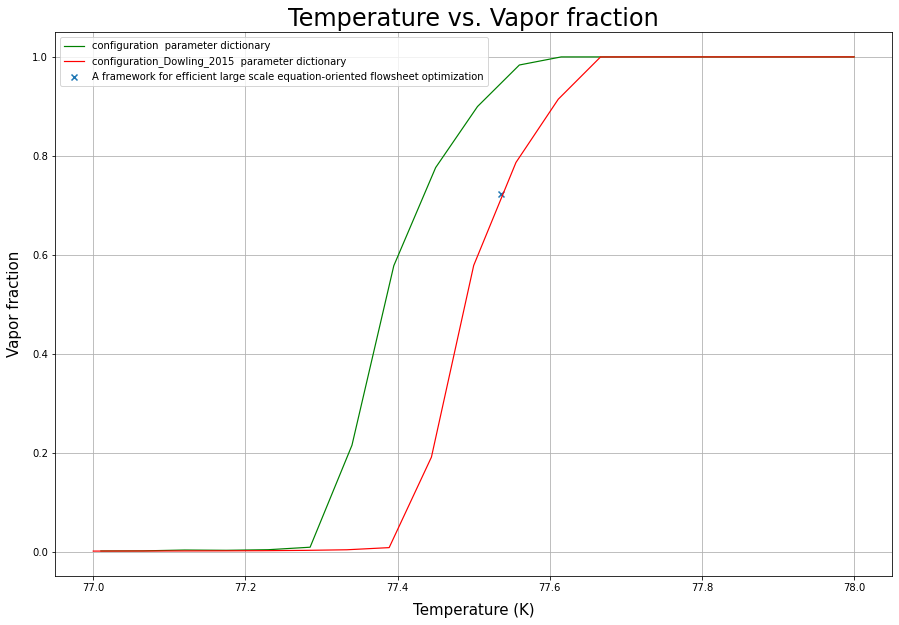

In [37]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(T1, x1,"g",label="configuration  parameter dictionary",linewidth=1.2)
ax.plot(T2, x2,"r",label="configuration_Dowling_2015  parameter dictionary",linewidth=1.2)
plt.scatter(T_paper, x_paper,marker='x',label="A framework for efficient large scale equation-oriented flowsheet optimization")
ax.set_xlabel('Temperature (K)',fontsize=15, labelpad=10)
ax.set_ylabel('Vapor fraction',fontsize=15, labelpad=10)
ax.legend(fontsize=15)
plt.title("Temperature vs. Vapor fraction",fontsize=24)
ax.grid()
plt.legend()
plt.show()

From the plot, we can note the influence the thermodynamic equations and coefficients have.